In [4]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

AMD Ryzen 5 5600G 4.46GHz

Intel N100 

Text(0.5, 0, 'Generation')

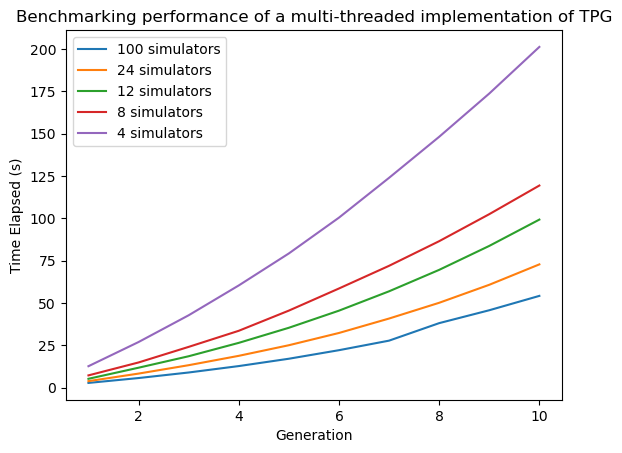

In [7]:
df_100 = pd.read_csv("lunar_lander_100_envs.csv")
df_24 = pd.read_csv("lunar_lander_24_envs.csv")
df_12 = pd.read_csv("lunar_lander_12_envs.csv")
df_8 = pd.read_csv("lunar_lander_8_envs.csv")
df_4 = pd.read_csv("lunar_lander_4_envs.csv")
plt.plot(df_100['generation'], df_100['time_elapsed'], label='100 simulators')
plt.plot(df_24['generation'], df_24['time_elapsed'], label='24 simulators')
plt.plot(df_12['generation'], df_12['time_elapsed'], label='12 simulators')
plt.plot(df_8['generation'], df_8['time_elapsed'], label='8 simulators')
plt.plot(df_4['generation'], df_4['time_elapsed'], label='4 simulators')
plt.legend()
plt.title("Benchmarking performance of a multi-threaded implementation of TPG")
plt.ylabel("Time Elapsed (s)")
plt.xlabel("Generation")

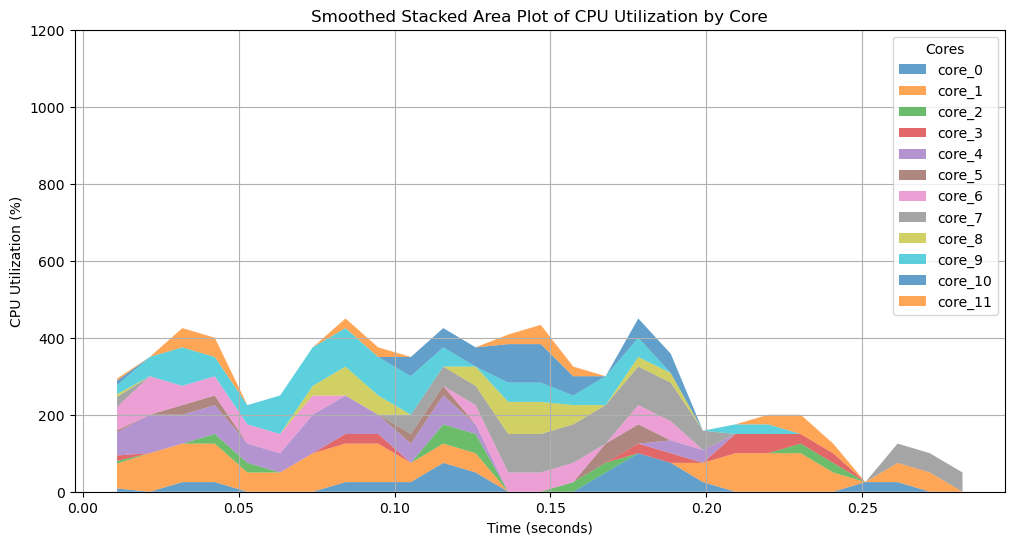

In [52]:
# Load the CSV file into a DataFrame
df = pd.read_csv('benchmarking/cpu_utilization.csv')

# Apply smoothing to the data
window_size = 2  # Number of points to average in moving average
df_smooth = df.copy()

# Apply moving average to each core's data
for column in df.columns[1:]:  # Skip the 'time' column
    df_smooth[column] = df[column].rolling(window=window_size, center=False).mean()

# Plotting
plt.figure(figsize=(12, 6))

plt.ylim(0, 1200)

# Generate the stacked area plot
plt.stackplot(df_smooth['time'], 
              [df_smooth[column] for column in df_smooth.columns[1:]], 
              labels=df_smooth.columns[1:], 
              alpha=0.7)

plt.xlabel('Time (seconds)')
plt.ylabel('CPU Utilization (%)')
plt.title('Smoothed Stacked Area Plot of CPU Utilization by Core')
plt.legend(title='Cores')
plt.grid(True)
plt.show()

